# TP 4 : Classification de graphes et passage à l'échelle

Dans cette séance, nous commençons par nous intéresser à une nouvelle tâche pour les GNN, la classification de graphes entiers, avant d'aborder les possibilités de passage à l'échelle pour la classification de nœuds.

## Classification de graphes

Nous allons maintenant aborder une nouvelle tâche à laquelle permettent de répondre les GNNs : la classification de graphes entiers. Au lieu de chercher à classer des nœuds (ce qu'on a fait dans la séance précédente), nous allons utiliser un dataset de graphes et tenter de les catégoriser, à partir de leurs caractéristiques structurelles. Nous allons donc chercher des *embeddings* de graphes entiers capable de les séparer linéairement.

![title](./graph-classif-small.png)

La tâche la plus courante en classification de graphes est la prédiction de propriétés pour des molécules : les molécules sont représentés par des graphes, et la tâche consiste à inférer si une molécule inhibe (ou non) la réplication d'un virus (VIH, par exemple).

L'université TU Dortmund a collecté et rassemblé dans PyTorch Geometric un grand nombre de datasets dédiés à la classification de graphes. On les trouve dans [`torch_geometric.datasets.TUDataset`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.TUDataset). Nous allons regarder l'un des plus petits, appelé MUTAG.

In [2]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Nombre de graphes : {len(dataset)}')
print(f'Nombre d\'attributs : {dataset.num_features}')
print(f'Nombre de classes : {dataset.num_classes}')

data = dataset[0]  # on prend le premier

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Nombre de nœuds : {data.num_nodes}')
print(f'Nombre d\'arêtes : {data.num_edges}')
print(f'Degré moyen : {data.num_edges / data.num_nodes:.2f}')
print(f'Nœuds isolés : {data.contains_isolated_nodes()}')
print(f'Boucles : {data.contains_self_loops()}')
print(f'Est non-orienté : {data.is_undirected()}')

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 94.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 65.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 23.7 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-_hiibupu
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-_hiibupu
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 36aed7c28140a54f27aea6c2429636ff0d1c84b8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.5 MB/s eta 0:00:00
  Created wh

Processing...
Done!
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


Le dataset contient 188 graphes, et la tâche consiste à les affecter dans l'une des deux classes.
Le premier graphe contient 17 nœuds (avec des vecteurs de dimension 7), et 38 arêtes (degré moyen 2,24). Il contient exactement une étiquette (y=[1]) et contient également des attributs d'arêtes (dimension 4 dans `edge_attr`), mais pour simplifier nous n'allons pas les utiliser.

PyTorch Geometric fournit des outils pour travailler avec les datasets de graphes : nous pouvons par exemple réordonner aléatoirement les graphes et utiliser les 150 premiers pour l'entraînement, tout en utilisant les derniers comme test.

In [3]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Nombre de graphes pour l\'apprentissage: {len(train_dataset)}')
print(f'Nombre de graphes pour le test : {len(test_dataset)}')

Nombre de graphes pour l'apprentissage: 150
Nombre de graphes pour le test : 38


### Traitement par mini-batchs

Comme la classification de graphes traite généralement de graphes de petite taille, c'est souvent une bonne idée de les regrouper en lot avant de les mettre en entrée d'un GNN, de façon à optimiser l'utilisation du GPU. Dans le domaine des images, on procède souvent à une mise à l'échelle (*rescaling*) de chaque exemple, afin de disposer d'exemples de tailles identiques. Les exemples sont ensuite regroupés dans une dimension supplémentaire, dont la dimension est égale au nombre d'exemples regroupés dans chaque "mini-batch", et on l'appelle généralement `batch_size`.
Cependant, dans le cas des GNN, ce n'est pas toujours possible et on risque d'avoir une consommation de mémoire exagérée. PyTorch Geometric propose donc une autre approche qui permet de paralléliser le traitement de plusieurs exemples. Les matrices d'adjacence sont empilées en diagonale (ce qui crée un graphe géant, contenant de nombreux sous-graphes indépendants). Les attributs de nœuds et les caractéristiques cibles sont concaténés.

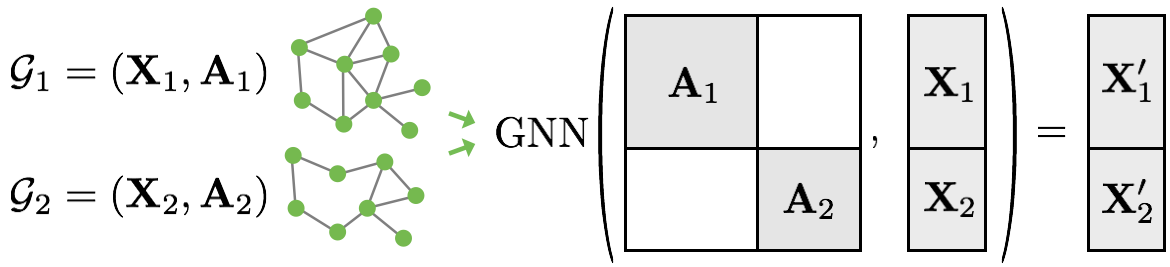

Cette procédure a de nombreux avantages sur les procédés classiques de *batching*:

   1. Les opérations de GNN, reposant sur le passage de message, n'ont pas besoin d'être modifiées, puisque les messages ne sont pas échangés d'un graphe à l'autre
   2. Les matrices d'adjacences sont stockées avec des structures dédiées aux matrices creuses, évitant la sur-consommation de mémoire/de CPU.
   
PyTorch Geometric réalise ce *batching* de graphes dans un seul graphe géant avec la classe [`torch_geometric.data.DataLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader) :

In [4]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Étape {step + 1}:')
    print('=======')
    print(f'Nombre de graphes dans ce batch : {data.num_graphs}')
    print(data)
    print()

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Étape 1:
Nombre de graphes dans ce batch : 64
DataBatch(edge_index=[2, 2636], x=[1188, 7], edge_attr=[2636, 4], y=[64], batch=[1188], ptr=[65])

Étape 2:
Nombre de graphes dans ce batch : 64
DataBatch(edge_index=[2, 2506], x=[1139, 7], edge_attr=[2506, 4], y=[64], batch=[1139], ptr=[65])

Étape 3:
Nombre de graphes dans ce batch : 22
DataBatch(edge_index=[2, 852], x=[387, 7], edge_attr=[852, 4], y=[22], batch=[387], ptr=[23])



On choisit une `batch_size`de 64, ce qui nous donne 3 mini-batches de $2 \cdot 64+22 = 150$ graphes.
Chaque objet `Batch` est pourvu d'un vecteur `batch`, qui fait correspondre chaque nœud à son graphe dans le lot.

### Entraînement d'un GNN pour la classification de graphe

Pour entraîner un GNN pour de la classification de graphe, on suit généralement une procédure assez simple :

   1. Calculer les embeddings de chaque nœud, avec plusieurs étapes de passage de message
   2. Agréger les embeddings de nœuds en un embedding de graphe unifié (ce qu'on appelle le *readout*)
   3. Entraîner un classifieur sur les embeddings de graphes

Il existe de nombreuses couches de *readout*, mais la plus simple consiste à prendre la moyenne des embeddings :
$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

PyTorch Geometric la propose avec [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool), qui prend les embeddings de tous les nœuds d'un mini-batch et le vecteur `batch` de leurs affectations, pour calculer un embedding de graphe de taille `[batch_size, hidden_channels]` pour chaque graphe du mini-batch.

L'architecture finale pour faire de la classification de graphe ressemble à ce qui suit, permettant un entraînement de bout en bout :

In [5]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


On utilise à nouveau la couche [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), avec l'activation $\mathrm{ReLU}(x) = \max(x, 0)$ pour obtenir les embeddings de nœuds, avant d'appliquer le classifieur final après la couche de *readout* (sur les graphes).

Entraînons notre réseau sur quelques epoch, pour observer ses performances sur le *training set* et le *test set*.

In [6]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 201):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 002, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 003, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 004, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 005, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 006, Train Acc: 0.6533, Test Acc: 0.7368
Epoch: 007, Train Acc: 0.7467, Test Acc: 0.7632
Epoch: 008, Train Acc: 0.7267, Test Acc: 0.7632
Epoch: 009, Train Acc: 0.7200, Test Acc: 0.7632
Epoch: 010, Train Acc: 0.7133, Test Acc: 0.7895
Epoch: 011, Train Acc: 0.7200, Test Acc: 0.7632
Epoch: 012, Train Acc: 0.7200, Test Acc: 0.7895
Epoch: 013, Train Acc: 0.7200, Test Acc: 0.7895
Epoch: 014, Train Acc: 0.7133, Test Acc: 0.8421
Epoch: 015, Train Acc: 0.7133, Test Acc: 0.8421
Epoch: 016, Train Acc: 0.7533, Test Acc: 0.7368
Epoch: 017, Train Acc: 0.7400, Test Acc: 0.7632
Epoch: 018, Train Acc: 0.7133, Test Acc: 0.8421
Epoch: 019, Train Acc: 0.7400, Test Acc: 0.7895
Epoch: 020, Train Acc: 0.7533, Test Acc: 0.7368
Epoch: 021, Train Acc: 0.7467, Test Acc:

**Question :** Quelle performance obtenez-vous ? Qu'en pensez-vous ? Proposez une explication.

On atteint 76% d'*accuracy*. Cela fluctue toutefois un peu, sans doute en raison de la taille réduite du dataset (seulement 38 graphes). Cela devrait disparaître si on utilisait des datasets plus grands.

### Bonus

Peut-on faire mieux ?
Plusieurs articles ([Xu et al. (2018)](https://arxiv.org/abs/1810.00826), [Morris et al. (2018)](https://arxiv.org/abs/1810.02244))) ont montré qu'une normalisation de voisinage réduisait l'expressivié des GNNs, c'est-à-dire leur capacité à distinguer certaines structures.

Avec l'ajout d'un raccourci (*skip-connection*), on peut omettre complètement cette normalisation et préserver l'information centrale sur le nœud ([Morris et al. (2018)](https://arxiv.org/abs/1810.02244)) :

$$
\mathbf{x}_v^{(\ell+1)} = \mathbf{W}^{(\ell + 1)}_1 \mathbf{x}_v^{(\ell)} + \mathbf{W}^{(\ell + 1)}_2 \sum_{w \in \mathcal{N}(v)} \mathbf{x}_w^{(\ell)}
$$

Cette couche est implémentée avec le nom [`GraphConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv). En complètant le code ci-dessous (voir les TODO), pour utiliser `GraphConv` plutôt que `GCNConv`, vous devriez arriver à 82% d'accuracy environ.

In [7]:
from torch_geometric.nn import GraphConv


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = ...  # TODO
        self.conv2 = ...  # TODO
        self.conv3 = ...  # TODO
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GNN(hidden_channels=64)
print(model)

GNN(
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [8]:
model = GNN(hidden_channels=64)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 201):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

GNN(
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


TypeError: 'ellipsis' object is not callable

## Passage à l'échelle

Pour faire de la classification de nœud, nous n'avons entraîné les GNN qu'en travaillant sur la totalité des données. Les représentations cachées de chaque nœud étaient calculées en parallèle et étaient disponibles pour les couches suivantes.

Quand on veut travailler sur des graphes de grande taille, cela n'est cependant plus possible, puisque cela ferait exploser l'usage de la mémoire. À titre d'exemple, un graphe de 10 millions de sommets et une représentation cachée de taille 128 a besoin de 5 Go de mémoire GPU par couche.

Il y a donc eu des tentatives pour permettre le passage à l'échelle des GNN. Nous allons regarder Cluster-GCN ([Chiang et al. (2019)](https://arxiv.org/abs/1905.07953), qui repose sur un pré-partitionnement du graphe en sous-graphes, sur lequel on peut travailler en mini-batchs.

### Données PubMed

Les données sur lesquelles on travaille proviennent de la base PubMed (contenant des articles de recherche en médecine). Elles se chargent à partir du package `Planetoid` (données provenant de [Yang et al. (2016)](https://arxiv.org/abs/1603.08861)).

In [9]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('==================')
print(f'Nombre de graphes: {len(dataset)}')
print(f'Nombre d\'attributs: {dataset.num_features}')
print(f'Nombre de classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===============================================================================================================')

# Gather some statistics about the graph.
print(f'Nombre de nœuds: {data.num_nodes}')
print(f'Nombre d\'arêtes: {data.num_edges}')
print(f'Degré moyen: {data.num_edges / data.num_nodes:.2f}')
print(f'Nombre de nœuds d\'entraînement: {data.train_mask.sum()}')
print(f'Fraction de nœuds d\'entraînement étiquetés: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Nœuds isolés: {data.contains_isolated_nodes()}')
print(f'Boucles: {data.contains_self_loops()}')
print(f'Est non-orienté: {data.is_undirected()}')

Processing...
Done!



Dataset: PubMed():
Nombre de graphes: 1
Nombre d'attributs: 500
Nombre de classes: 3

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Nombre de nœuds: 19717
Nombre d'arêtes: 88648
Degré moyen: 4.50
Nombre de nœuds d'entraînement: 60
Fraction de nœuds d'entraînement étiquetés: 0.003
Nœuds isolés: False
Boucles: False
Est non-orienté: True


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


Ce graphe a près de 20 000 sommets. Il pourrait tenir relativement facilement en mémoire, mais il va nous permettre d'illustrer le passage à l'échelle avec PyTorch Geometric.

### Principe de Cluster-GCN

Au début de l'algorithme Cluster-GCN ([Chiang et al. (2019)](https://arxiv.org/abs/1905.07953), on commence par partitionner un graphe en sous-graphes, avec l'aide d'algorithme dédiés. Ainsi, le GNN ne peut ensuite que travailler à l'intérieur du sous-graphe ainsi défini, ce qui limite l'explosion calculatoire liée au voisinage.

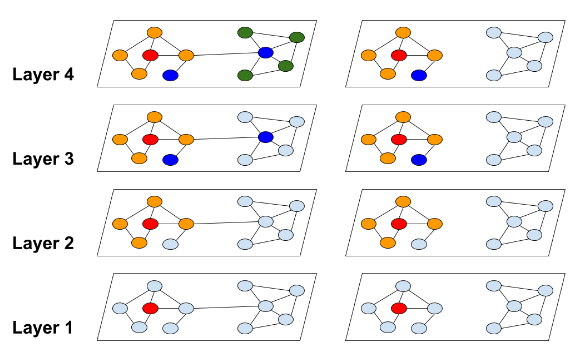

Toutefois, une fois le graphe partitionné, des liens sont retirés, ce qui peut limiter un peu la perfomance (biais). Pour pallier cette limite, Cluster-GCN inclut des liens *inter-clusters* dans un mini-batch, ce qui donne le partitionnement stochastique suivant :

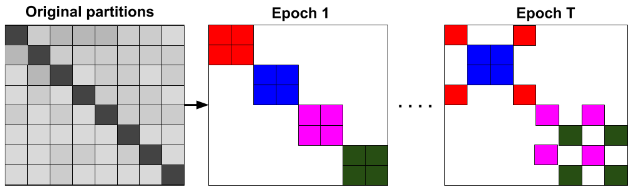

Les couleurs représentent l'information sur l'adjacence qui est préservée dans chaque batch (qui peut potentiellement varier à chaque epoch).

PyTorch Geometric fournit une implementation de Cluster-GCN en deux étapes :
   1. [`ClusterData`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.ClusterData) convertit un objet `Data` en un dataset de sous-graphes, qui contiennent `num_parts` partitions.
   2. Pour une `batch_size` donnée, [`ClusterLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.ClusterLoader) réalise le partitionnement stochastique afin de créer les mini-batchs.

La procédure de création des mini-batchs est la suivante :

In [10]:
from torch_geometric.data import ClusterData, ClusterLoader

torch.manual_seed(12345)
cluster_data = ClusterData(data, num_parts=128)  # 1. Create subgraphs.
train_loader = ClusterLoader(cluster_data, batch_size=32, shuffle=True)  # 2. Stochastic partioning scheme.

print()
total_num_nodes = 0
for step, sub_data in enumerate(train_loader):
    print(f'Étape {step + 1}:')
    print('=======')
    print(f'Nombre de nœuds dans le batch courant : {sub_data.num_nodes}')
    print(sub_data)
    print()
    total_num_nodes += sub_data.num_nodes

print(f'Parcours de {total_num_nodes} nœuds sur {data.num_nodes} !')

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.ClusterData' is deprecated, use 'loader.ClusterData' instead
  warnings.warn(out)
Computing METIS partitioning...



Étape 1:
Nombre de nœuds dans le batch courant : 4928
Data(x=[4928, 500], y=[4928], train_mask=[4928], val_mask=[4928], test_mask=[4928], edge_index=[2, 16174])

Étape 2:
Nombre de nœuds dans le batch courant : 4937
Data(x=[4937, 500], y=[4937], train_mask=[4937], val_mask=[4937], test_mask=[4937], edge_index=[2, 17832])

Étape 3:
Nombre de nœuds dans le batch courant : 4927
Data(x=[4927, 500], y=[4927], train_mask=[4927], val_mask=[4927], test_mask=[4927], edge_index=[2, 14712])

Étape 4:
Nombre de nœuds dans le batch courant : 4925
Data(x=[4925, 500], y=[4925], train_mask=[4925], val_mask=[4925], test_mask=[4925], edge_index=[2, 18006])

Parcours de 19717 nœuds sur 19717 !


Done!
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.ClusterLoader' is deprecated, use 'loader.ClusterLoader' instead
  warnings.warn(out)


On partitionne le graphe en 128 sous-graphes indépendants, et l'on utilise une `batch_size` de 32 : on a donc 4 batchs (contenant chacun 32 graphes) à traiter à chaque epoch. Après une epoch, chaque nœud a été vu exactement une fois.

Ce qui est intéressant avec Cluster-GCN, c'est qu'il ne complique pas l'implémentation du modèle GNN, on peut réutiliser ce qu'on a vu dans la séance précédente.

In [11]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(500, 16)
  (conv2): GCNConv(16, 3)
)


### Entraînement

Pour entraîner ce GNN, on procède presque pareil que pour la classification de graphes. Au lieu de travailler sur l'ensemble du graphe, on itère sur chaque mini-batch, et l'on optimise chaque batch indépendamment des autres.

In [12]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()

      for sub_data in train_loader:  # Iterate over each mini-batch.
          out = model(sub_data.x, sub_data.edge_index)  # Perform a single forward pass.
          loss = criterion(out[sub_data.train_mask], sub_data.y[sub_data.train_mask])  # Compute the loss solely based on the training nodes.
          loss.backward()  # Derive gradients.
          optimizer.step()  # Update parameters based on gradients.
          optimizer.zero_grad()  # Clear gradients.

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.

      accs = []
      for mask in [data.train_mask, data.val_mask, data.test_mask]:
          correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
          accs.append(int(correct.sum()) / int(mask.sum()))  # Derive ratio of correct predictions.
      return accs

for epoch in range(1, 51):
    loss = train()
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train: 0.3333, Val Acc: 0.4160, Test Acc: 0.4070
Epoch: 002, Train: 0.4833, Val Acc: 0.4420, Test Acc: 0.4270
Epoch: 003, Train: 0.7333, Val Acc: 0.5220, Test Acc: 0.5160
Epoch: 004, Train: 0.8333, Val Acc: 0.5920, Test Acc: 0.5930
Epoch: 005, Train: 0.9167, Val Acc: 0.6920, Test Acc: 0.6810
Epoch: 006, Train: 0.9000, Val Acc: 0.6680, Test Acc: 0.6680
Epoch: 007, Train: 0.8833, Val Acc: 0.6520, Test Acc: 0.6530
Epoch: 008, Train: 0.9167, Val Acc: 0.7020, Test Acc: 0.6940
Epoch: 009, Train: 0.9333, Val Acc: 0.7340, Test Acc: 0.7290
Epoch: 010, Train: 0.9333, Val Acc: 0.6880, Test Acc: 0.6900
Epoch: 011, Train: 0.9500, Val Acc: 0.7240, Test Acc: 0.7330
Epoch: 012, Train: 0.9500, Val Acc: 0.7500, Test Acc: 0.7300
Epoch: 013, Train: 0.9667, Val Acc: 0.7680, Test Acc: 0.7530
Epoch: 014, Train: 0.9667, Val Acc: 0.7600, Test Acc: 0.7450
Epoch: 015, Train: 0.9667, Val Acc: 0.7680, Test Acc: 0.7550
Epoch: 016, Train: 0.9667, Val Acc: 0.7660, Test Acc: 0.7630
Epoch: 017, Train: 0.966

**Question :** Qu'observez-vous ?

La performance, autour de 78% d'*accuracy* est bonne. Surtout, elle est obtenue en utilisant une technique de traitement par lot (*batch*), donc avec des données non globales.